<a href="https://colab.research.google.com/github/Shriteen/cyberbullying-classifier/blob/shri3/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Shriteen/cyberbullying-classifier.git

Cloning into 'cyberbullying-classifier'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 15 (delta 5), reused 2 (delta 0), pack-reused 0
Unpacking objects: 100% (15/15), 2.79 MiB | 4.45 MiB/s, done.


In [2]:
!cp cyberbullying-classifier/cyberbullying_tweets.csv .

Import Dependancies

In [11]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

Load data from dataset

In [12]:
df= pd.read_csv("cyberbullying_tweets.csv")
df.columns = ['tweet_text', 'cyberbullying_type']

# oversample not_cyberbullying
df=pd.concat([df, df[df['cyberbullying_type']=='not_cyberbullying'] ])

df['category_id']= df['cyberbullying_type'].factorize()[0]
df.head()

,tweet_text,cyberbullying_type,category_id
0,"In other words #katandandre, your food was cra...",not_cyberbullying,0
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,0
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,0
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,0
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,0


Create dictionaries to simplify future use

In [13]:
category_id_df = df[['cyberbullying_type', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'cyberbullying_type']].values)

Create tf-idf vector object
- sublinear to use a logarithmic form for frequency     
- min_df = 5 means ignore tokens with count lower than 5
- norm='l2' used to convert vector to unit vector       
- ngram_range is to include uni,bi and trigrams         
- stop_words is to ignore english stop words            

In [14]:
tfidf= TfidfVectorizer(sublinear_tf=True,
                           min_df=8,
                           norm='l2',
                           ngram_range=(1,3),
                           encoding='latin-1',
                           stop_words="english")


Convert text to vector form

In [15]:
features= tfidf.fit_transform(df.tweet_text).toarray()
labels= df.category_id
features.shape


(55637, 14165)

Extract and Display the top features of each category

In [16]:
from sklearn.feature_selection import chi2
import numpy as np

for category,category_id in sorted(category_to_id.items()):
  features_chi2= chi2(features, labels==category_id )
  indices = np.argsort(features_chi2[0])
  feature_names= np.array(tfidf.get_feature_names_out())[indices]

  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  trigrams = [v for v in feature_names if len(v.split(' ')) == 3]
  
  print('#'+category)
  print('Unigrams:',','.join(unigrams[-5:]))
  print('Bigrams:',','.join(bigrams[-5:]))
  print('Trigrams:',','.join(trigrams[-5:]))
  

#age
Unigrams: girl,bullies,bullied,high,school
Bigrams: girl bullied,girls bullied,school bully,bullied high,high school
Trigrams: high school bullies,high school bully,girl bullied high,girls bullied high,bullied high school
#ethnicity
Unigrams: ass,niggers,fuck,nigger,dumb
Bigrams: fuck obama,dumb fuck,ass nigger,dumb nigger,dumb ass
Trigrams: fuck dumb nigger,tayyoung_ fuck obama,obama dumb ass,fuck obama dumb,dumb ass nigger
#gender
Unigrams: sexist,joke,jokes,gay,rape
Bigrams: jokes rape,gay rape,gay jokes,rape joke,rape jokes
Trigrams: gay rape joke,jokes rape jokes,jokes gay jokes,rape jokes gay,gay rape jokes
#not_cyberbullying
Unigrams: http,nigger,dumb,bullying,mkr
Bigrams: dumb nigger,bullied high,dumb ass,kat andre,high school
Trigrams: tayyoung_ fuck obama,obama dumb ass,fuck obama dumb,dumb ass nigger,bullied high school
#other_cyberbullying
Unigrams: freebsdgirl,dumb,school,blameonenotall,https
Bigrams: maine coon,bully lol,blameonenotall http,idiot https,high school
Tr

Try with different algorithms

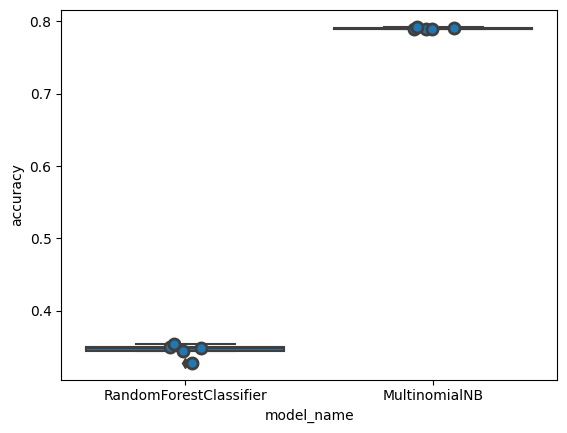

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score

models=[ RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
         MultinomialNB() ]

CV=5
cv_df= pd.DataFrame(index=range(CV* len(models)))
entries=[]

for model in models:
  model_name= model.__class__.__name__
  accuracies= cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name,fold_idx,accuracy))
cv_df= pd.DataFrame(entries, columns=['model_name','fold_idx','accuracy'])

import seaborn as sns
import matplotlib.pyplot as plt
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()


Display accuracy of algorithms

In [18]:
cv_df.groupby('model_name').accuracy.mean()

model_name
MultinomialNB             0.790158
RandomForestClassifier    0.345166
Name: accuracy, dtype: float64

Plot confusion matrix

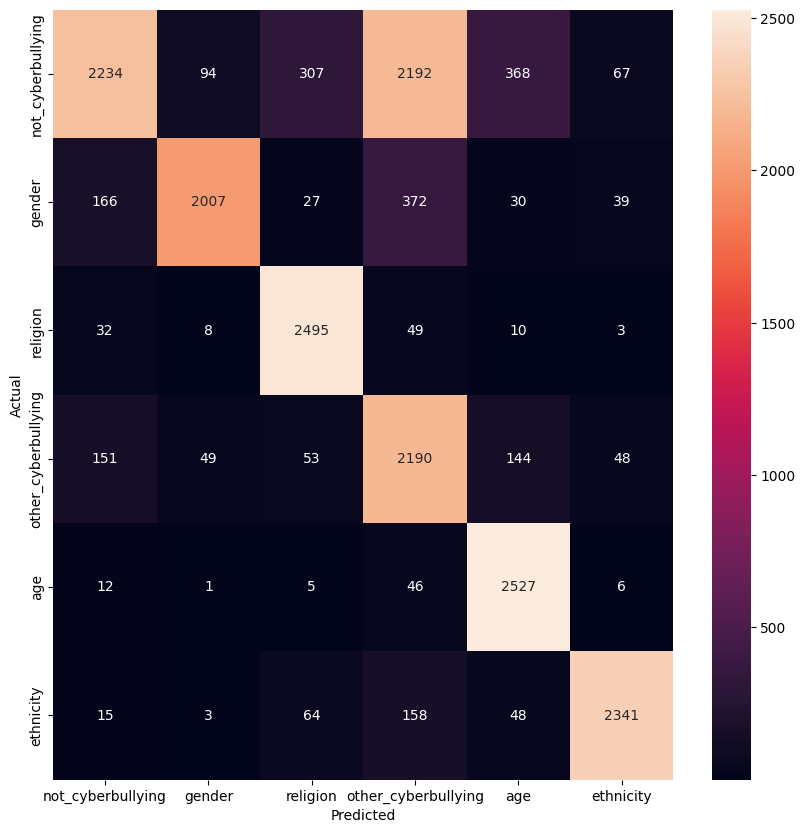

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

model= MultinomialNB(class_prior=[0.05,0.05,0.05,0.1,0.07,0.05])

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features,labels,df.index,test_size=0.33, random_state=0)

model.fit(X_train,y_train)

y_pred= model.predict(X_test)

from sklearn.metrics import confusion_matrix

conf_mat= confusion_matrix(y_test, y_pred)

fig,ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d', 
            xticklabels=category_id_df.cyberbullying_type.values, 
            yticklabels=category_id_df.cyberbullying_type.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [20]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=df['cyberbullying_type'].unique()))

                     precision    recall  f1-score   support

  not_cyberbullying       0.86      0.42      0.57      5262
             gender       0.93      0.76      0.84      2641
           religion       0.85      0.96      0.90      2597
other_cyberbullying       0.44      0.83      0.57      2635
                age       0.81      0.97      0.88      2597
          ethnicity       0.93      0.89      0.91      2629

           accuracy                           0.75     18361
          macro avg       0.80      0.81      0.78     18361
       weighted avg       0.81      0.75      0.75     18361



Train model using Naive Bayes

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df['tweet_text'],df['cyberbullying_type'], random_state=0)
count_vect= CountVectorizer()
X_train_counts= count_vect.fit_transform(X_train)
tfidf_transformer= TfidfTransformer()
X_train_tfidf= tfidf_transformer.fit_transform(X_train_counts)

classifier= MultinomialNB(class_prior=[0.05,0.05,0.05,0.1,0.07,0.05]).fit(X_train_tfidf, y_train)

Prediction Test field

In [24]:
classifier.predict( count_vect.transform(["Test of model "]) )

array(['not_cyberbullying'], dtype='<U19')